導入所需的庫和模塊

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D


數據預處理
在構建神經網絡之前，我們需要對數據進行一些預處理。我們可以將圖像像素值縮放到 0 到 1 的範圍，並對標籤進行編碼。
使用了 Keras 的 to_categorical 函數將標籤數據轉換為 one-hot 編碼。

to_categorical 函數將整數類型的標籤轉換為對應的 one-hot 編碼表示。對於有 num_classes 個類別的分類問題，one-hot 編碼將標籤表示為一個長度為 num_classes 的向量，其中只有一個元素為 1，其餘元素都為 0，用於表示樣本所屬的類別。

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
'''
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(96, 96), #改變尺寸
  layers.Rescaling(1./127.5, offset=-1) #[-1,1]浮點數範圍
])
'''

x_train_normalize = tf.image.resize(x_train/127.5 - 1.0, [96,96]) #轉成適合MobileNet的[-1,1]浮點數範圍

x_test_normalize = tf.image.resize(x_test/127.5 - 1.0 , [96,96])

y_train_OneHot = keras.utils.to_categorical(y_train)
y_test_OneHot = keras.utils.to_categorical(y_test)



print("train data:",'images:',x_train.shape,
      " labels:",y_train.shape) 
print("test  data:",'images:',x_test.shape ,
      " labels:",y_test.shape) 

train data: images: (50000, 32, 32, 3)  labels: (50000, 1)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 1)


構建神經網絡模型 
在訓練模型之前，我們需要編譯模型並指定損失函數、優化器和評估指標。

In [4]:
base_mod=tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
    include_top= False,
    weights='imagenet') #權重

fine_tune=100
for layer in base_mod.layers[:fine_tune]:
    layer.trainable= False          #前100層不調整

ins= tf.keras.Input(shape=(96,96,3))

x=base_mod(ins)
x=tf.keras.layers.GlobalAveragePooling2D()(x)   #平均
x=tf.keras.layers.Dropout(0.2)(x)           #20%節點設成0
x=tf.keras.layers.Dense(120,activation='relu')(x)
outs=tf.keras.layers.Dense(10, activation='softmax')(x)     #換算成機率
model=tf.keras.Model(ins,outs)

loss_f=tf.keras.losses.CategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss=loss_f, metrics=['accuracy'])

print(model.summary)




<bound method Model.summary of <keras.engine.functional.Functional object at 0x000001BF9827E210>>


繪圖

In [5]:
import matplotlib.pyplot as plt
def show_acc_train_history(train_acc,val_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[val_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def show_loss_train_history(train_loss,val_loss):
    plt.plot(train_history.history[train_loss])
    plt.plot(train_history.history[val_loss])
    plt.title('Train History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

訓練模型並劃出示意圖
使用 fit 函數來訓練模型。我們使用了批量大小為 64，迭代次數為 10。我們還使用測試集作為驗證集來評估模型的性能。

Epoch 1/10
625/625 [==============================] - 468s 722ms/step - loss: 0.6918 - accuracy: 0.7808 - val_loss: 11.4534 - val_accuracy: 0.1830
Epoch 2/10
625/625 [==============================] - 361s 578ms/step - loss: 0.4292 - accuracy: 0.8603 - val_loss: 2.6273 - val_accuracy: 0.5239
Epoch 3/10
625/625 [==============================] - 358s 573ms/step - loss: 0.3506 - accuracy: 0.8842 - val_loss: 1.6143 - val_accuracy: 0.6617
Epoch 4/10
625/625 [==============================] - 359s 575ms/step - loss: 0.3017 - accuracy: 0.9020 - val_loss: 3.2419 - val_accuracy: 0.6064
Epoch 5/10
625/625 [==============================] - 355s 568ms/step - loss: 0.2601 - accuracy: 0.9144 - val_loss: 3.3610 - val_accuracy: 0.6070
Epoch 6/10
625/625 [==============================] - 338s 541ms/step - loss: 0.2196 - accuracy: 0.9276 - val_loss: 2.5779 - val_accuracy: 0.6691
Epoch 7/10
625/625 [==============================] - 341s 545ms/step - loss: 0.1929 - accuracy: 0.9365 - val_loss: 1.4138 

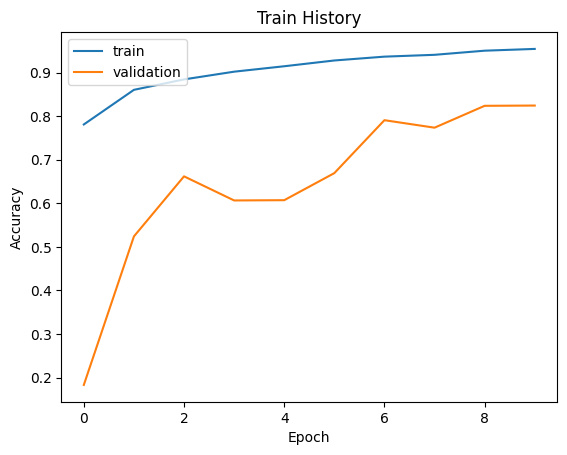

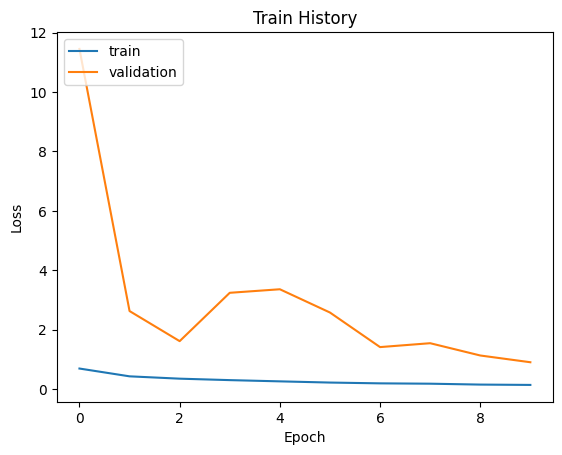

In [6]:
train_history=model.fit(x_train_normalize, y_train_OneHot, batch_size=64, epochs=10, validation_split=0.2,verbose=1)
show_acc_train_history('accuracy','val_accuracy')
show_loss_train_history('loss','val_loss')

呈現 Test Loss & Test Accuracy

In [7]:
test_loss, test_accuracy = model.evaluate(x_test_normalize, y_test_OneHot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



313/313 [==============================] - 48s 154ms/step - loss: 0.8799 - accuracy: 0.8308
Test Loss: 0.8799375295639038
Test Accuracy: 0.8307999968528748


# 顯示預測機率和混淆矩陣
使用了 pandas 庫中的 crosstab 函數來創建一個交叉表（或稱為列聯表），以對比測試集中真實標籤和模型的預測結果。
交叉表將真實標籤和預測結果進行對比，並以表格的形式顯示它們之間的關係。表的行表示真實標籤，表的列表示預測結果。交叉表的每個單元格表示真實標籤與預測結果的對應數量。

313/313 [==============================] - 49s 137ms/step
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


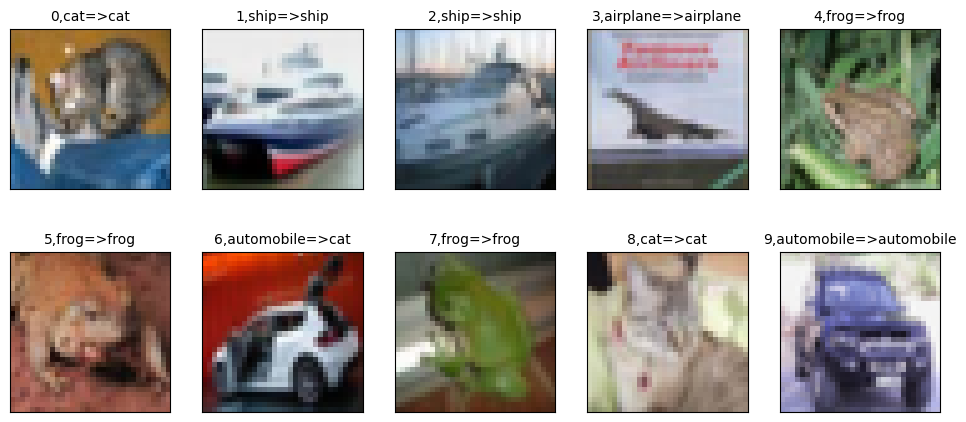

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,903,0,37,2,7,0,0,2,43,6
1,58,795,9,70,2,8,2,2,22,32
2,28,0,881,7,24,38,7,12,1,2
3,32,0,61,542,10,290,8,41,13,3
4,20,0,78,10,789,48,5,44,6,0
5,12,1,21,36,10,868,1,46,4,1
6,8,0,60,25,17,43,818,10,16,3
7,18,1,14,2,25,15,1,916,8,0
8,26,5,5,2,1,0,0,0,956,5


In [8]:
prediction=np.argmax(model.predict(x_test_normalize), axis=-1)
prediction[:10]
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
print(label_dict)

def plot_images_labels_prediction(images,labels,prediction,
                                  idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx],cmap='binary')
                
        title=str(i)+','+label_dict[labels[i][0]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[i]]
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

plot_images_labels_prediction(x_test,y_test,
                              prediction ,0,10)


import pandas as pd


pd.crosstab(y_test.reshape(-1),prediction,
            rownames=['label'],colnames=['predict'])